In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46517")
client

<Client: 'tcp://127.0.0.1:46517' processes=8 threads=32, memory=125.87 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xgcm.grid import Grid
from scipy.interpolate import griddata
import gsw
import xrft
import xwavelet
import sys
import s3fs
import os.path as op
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
odir = '/tank/users/tuchida/oceanbench'
sys.path.insert(0, odir)
sys.path

['/tank/users/tuchida/oceanbench',
 '/tank/users/tuchida/oceanbench/notebooks/dev/eman',
 '/tank/spectre/tuchida/envs/jax/lib/python39.zip',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9/lib-dynload',
 '',
 '/tank/users/tuchida/.local/lib/python3.9/site-packages',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages',
 '/tank/topog/tuchida/xwavelet',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages/xoa-0.6.1-py3.9.egg',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages/setuptools-67.6.1-py3.9.egg',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages/pytest-7.3.1-py3.9.egg',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages/configobj-5.0.8-py3.9.egg',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages/cmocean-3.0.3-py3.9.egg',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages/appdirs-1.4.4-py3.9.egg',
 '/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages/excep

In [4]:
from oceanbench._src.geoprocessing.gridding import interp_da

ModuleNotFoundError: No module named 'ESMF'

In [5]:
import esmpy

ImportError: The ESMFMKFILE environment variable is not available.

In [7]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [8]:
reg = 1
dss = cat.eNATL60(region=str(reg),datatype='surface_hourly', season='fma'
                 ).to_dask()[dict({'time_counter':range(0,89*24+1,120)})
                            ] # every 120 seconds, i.e. 5 days

dss

<xarray.Dataset>
Dimensions:        (y: 763, x: 611, time_counter: 18)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

## Prepare `xgcm.Grid` object

In [9]:
YC = dss.lat.mean('x')
XC = dss.lon.mean('y')
YG = xr.concat([YC[0]-YC.diff('y').min(skipna=True),
                .5*(YC[1:] + YC[:-1])
               ],'y')
XG = xr.concat([XC[0]-XC.diff('x').min(skipna=True),
                .5*(XC[1:] + XC[:-1])
               ],'x')
v  = xr.DataArray(dss.somecrty.data, dims=['time','YG','XC'],
                  coords={'YG':YG.data,'XC':XC.data}
                 )
u  = xr.DataArray(dss.sozocrtx, dims=['time','YC','XG'],
                  coords={'YC':YC.data,'XG':XG.data}
                 )
ds = u.to_dataset(name='UVEL')
ds['VVEL'] = v
ds.coords['lat'] = xr.DataArray(dss.lat.data, dims=['YC','XC'],
                           coords={'YC':YC.data,'XC':XC.data}
                          )
ds.coords['lon'] = xr.DataArray(dss.lon.data, dims=['YC','XC'],
                           coords={'YC':YC.data,'XC':XC.data}
                          )
ds.coords['maskC'] = xr.DataArray(dss.tmask.data, dims=['YC','XC'],
                           coords={'YC':YC.data,'XC':XC.data}
                          )
ds.coords['DXU'] = xr.DataArray(dss.e1u.data,
                   dims=['YC','XG'], 
                   coords={'YC':YC.data,'XG':XG.data}
                  )
ds.coords['DYU'] = xr.DataArray(dss.e2u.data,
                   dims=['YC','XG'], 
                   coords={'YC':YC.data,'XG':XG.data}
                  )
ds.coords['DXV'] = xr.DataArray(dss.e1v.data,
                   dims=['YG','XC'], 
                   coords={'YG':YG.data,'XC':XC.data}
                  )
ds.coords['DYV'] = xr.DataArray(dss.e2v.data,
                   dims=['YG','XC'], 
                   coords={'YG':YG.data,'XC':XC.data}
                  )
ds.coords['DXT'] = xr.DataArray(dss.e1t.data,
                   dims=['YC','XC'], 
                   coords={'YC':YC.data,'XC':XC.data}
                  )
ds.coords['DYT'] = xr.DataArray(dss.e2t.data,
                   dims=['YC','XC'], 
                   coords={'YC':YC.data,'XC':XC.data}
                  )
ds.coords['DXF'] = xr.DataArray(dss.e1f.data,
                   dims=['YG','XG'], 
                   coords={'YG':YG.data,'XG':XG.data}
                  )
ds.coords['DYF'] = xr.DataArray(dss.e2f.data,
                   dims=['YG','XG'], 
                   coords={'YG':YG.data,'XG':XG.data}
                  )
ds = ds.chunk({'time':1,'YC':100,'XC':100})

In [10]:
coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        "T": {"center": "time", }
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
T Axis (not periodic, boundary=None):
  * center   time

## Interpolate $u$ and $v$ to the cell center

In [11]:
u = grid.interp(ds.UVEL,'X',boundary='extend'
               ).sel(YC=slice(32,39),XC=slice(-74,-68)) # avoid land
v = grid.interp(ds.VVEL,'Y',boundary='extend'
               ).sel(YC=slice(32,39),XC=slice(-74,-68)) # avoid land

## Interpolate onto horizontal monotonic grid with metric units with finite volume consideration

In [13]:
XT = grid.cumsum(ds.DXU,'X',boundary='extend'
                ).sel(YC=slice(32,39),XC=slice(-74,-68))
YT = grid.cumsum(ds.DYV,'Y',boundary='extend'
                ).sel(YC=slice(32,39),XC=slice(-74,-68))
ny,nx = XT.shape
xT = (XT - XT.isel(XC=nx//2)).values.flatten()
yT = (YT - YT.isel(YC=ny//2)).values.flatten()
dx = ds.DXT.sel(YC=slice(32,39),XC=slice(-74,-68)).min().values
dy = ds.DYT.sel(YC=slice(32,39),XC=slice(-74,-68)).min().values
yy = np.arange(-ny*dy/2,ny*dy/2,dy) # monotonic grid
xx = np.arange(-nx*dx/2,nx*dx/2,dx) # monotonic grid

In [15]:
area = (ds.DYT * ds.DXT).sel(YC=slice(32,39),XC=slice(-74,-68))
xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
Aterp = xr.DataArray(griddata((xT, yT), 
                              area.values.flatten(),
                              (xxx, yyy) 
                             ).T, 
                     dims=['YC','XC'],
                     coords={'YC':yy,'XC':xx}
                    )
Aterp

<xarray.DataArray (YC: 544, XC: 360)>
array([[2367560.49406227, 2367595.33829439, 2367634.06354894, ...,
        2381825.84506569, 2381855.48149366, 2381886.28717313],
       [2366770.89787457, 2366804.91618921, 2366843.29219709, ...,
        2381065.33558847, 2381090.64626408, 2381117.6767631 ],
       [2365976.88227915, 2366009.08473231, 2366046.71102551, ...,
        2380304.52427181, 2380325.90239059, 2380349.31233982],
       ...,
       [1925546.9310029 , 1925645.56645306, 1925764.33252197, ...,
        1961787.95611764, 1961830.48105074, 1961871.78274621],
       [1924740.42587351, 1924838.1858564 , 1924952.76164024, ...,
        1961005.41396358, 1961054.55958658, 1961102.68633141],
       [1923918.29293416, 1924015.61946824, 1924128.57827456, ...,
        1960223.65256987, 1960281.13254784, 1960337.85109279]])
Coordinates:
  * YC       (YC) float64 -3.622e+05 -3.609e+05 ... 3.595e+05 3.609e+05
  * XC       (XC) float64 -2.589e+05 -2.574e+05 -2.56e+05 ... 2.56e+05 2.574e+05

In [16]:
Uterp = xr.DataArray(np.zeros_like(u), 
                     dims=['time','YC','XC'],
                     coords={'YC':yy,'XC':xx}
                    )
Vterp = xr.DataArray(np.zeros_like(v), 
                     dims=['time','YC','XC'],
                     coords={'YC':yy,'XC':xx}
                    )

for tt in range(len(ds.time)):
    Uterp[dict(time=tt)] = griddata((xT, yT), 
                                    (u * area
                                    ).isel(time=tt,).values.flatten(),
                                    (xxx, yyy) 
                                   ).T 
    Vterp[dict(time=tt)] = griddata((xT, yT), 
                                    v.isel(time=tt).values.flatten(),
                                    (xxx, yyy) 
                                   ).T 
    print(tt)

Uterp = (Uterp / Aterp).chunk({'time':1})
Vterp = (Vterp / Aterp).chunk({'time':1})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


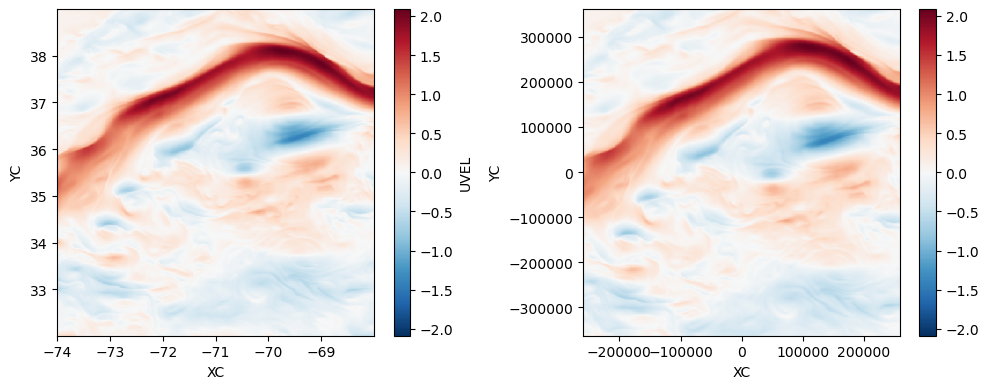

In [17]:
## Check interpolation

fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)

u.isel(time=0).plot(ax=ax1)
Uterp.isel(time=0).plot(ax=ax2)

## Compute isotropic wavenumber spectra
### Fourier

In [37]:
Fu_windowed = xrft.isotropic_power_spectrum(Uterp, dim=['YC','XC'], detrend='constant', 
                                            window='hann', window_correction=True,
                                   truncate=True)
Fv_windowed = xrft.isotropic_power_spectrum(Vterp, dim=['YC','XC'], detrend='constant', 
                                            window='hann', window_correction=True,
                                   truncate=True)
Fu = xrft.isotropic_power_spectrum(Uterp, dim=['YC','XC'], detrend='constant', 
                                   truncate=True)
Fv = xrft.isotropic_power_spectrum(Vterp, dim=['YC','XC'], detrend='constant', 
                                   truncate=True)

Feke_win = .5*(Fu_windowed+Fv_windowed).mean('time').compute()
Feke = .5*(Fu+Fv).mean('time').compute()
Feke

<xarray.DataArray (freq_r: 61)>
array([3.56086206e+03, 8.74854082e+02, 2.15279797e+02, 8.68705022e+01,
       4.70466978e+01, 2.82890626e+01, 1.85337537e+01, 1.30342687e+01,
       9.56886313e+00, 6.99622221e+00, 5.15368533e+00, 4.11008793e+00,
       3.24189163e+00, 2.57882498e+00, 2.10416897e+00, 1.71298031e+00,
       1.40182566e+00, 1.10017340e+00, 1.04236327e+00, 9.01431545e-01,
       7.88838615e-01, 6.71331169e-01, 6.00855532e-01, 5.30817074e-01,
       4.72355978e-01, 4.32679853e-01, 3.85019558e-01, 3.48390481e-01,
       3.19336865e-01, 2.95996359e-01, 2.76889986e-01, 2.57757461e-01,
       2.37988265e-01, 2.25103726e-01, 2.09906415e-01, 1.61769616e-01,
       1.94430910e-01, 1.85849863e-01, 1.78082196e-01, 1.71017189e-01,
       1.64382667e-01, 1.59697301e-01, 1.56975492e-01, 1.49344131e-01,
       1.44978176e-01, 1.41572293e-01, 1.38914949e-01, 1.35501995e-01,
       1.31728588e-01, 1.29509034e-01, 1.29810786e-01, 1.24775513e-01,
       1.14889974e-01, 9.97855655e-02, 1.21585204e-01, 1.21061870e-01,
       1.19654210e-01, 1.19146548e-01, 1.20393294e-01, 1.18061324e-01,
       1.17782350e-01])
Coordinates:
  * freq_r   (freq_r) float64 3.743e-06 8.869e-06 ... 0.0003383 0.000344

### Wavelet
While the wavenumber resolution of Fast Fourier Transforms is limited by the domain size, wavelet transforms allow for a flexible wavenumber resolution.

In [42]:
sf = Feke.freq_r**-1
sw = np.linspace(sf.min(), sf.max(), 20)
sw = xr.DataArray(sw, dims='scale', coords={'scale':sw})
s0 = 50e3                 # 50km: Characteristic length scale of interest
swh = np.concatenate((sf.where(sf<s0).dropna('freq_r').data[::-1],
                      sw.where(sw>s0).dropna('scale'))
                    )     # Increase wavenumber resolution for scales above s0
swh = xr.DataArray(swh, dims='scale', coords={'scale':swh}
                  ) / s0  # Non-dimensionalized length scales for the wavelet spectrum
swh

<xarray.DataArray (scale: 74)>
array([0.05813977, 0.05911967, 0.06013076, 0.06117388, 0.06225704,
       0.06337833, 0.06454174, 0.06574782, 0.06699732, 0.06829769,
       0.06964671, 0.0710534 , 0.07252574, 0.07405586, 0.07564176,
       0.07730007, 0.07903992, 0.08086114, 0.08276651, 0.08475658,
       0.08684718, 0.08904923, 0.0913627 , 0.09380153, 0.09637496,
       0.0990801 , 0.10193385, 0.10497594, 0.10823255, 0.11167741,
       0.11531431, 0.11920913, 0.12339567, 0.12790051, 0.13272802,
       0.1379163 , 0.14355159, 0.14965758, 0.15628137, 0.16356338,
       0.17157198, 0.1803471 , 0.19004931, 0.20093131, 0.2132478 ,
       0.22699177, 0.24251968, 0.26046649, 0.28123579, 0.30552753,
       0.33447172, 0.36966421, 0.41325297, 0.46832073, 0.53921129,
       0.63667764, 0.77899273, 0.99610138, 1.1706934 , 1.44883181,
       1.72697022, 2.00510863, 2.28324704, 2.56138545, 2.83952386,
       3.11766227, 3.39580068, 3.67393909, 3.95207749, 4.2302159 ,
       4.50835431, 4.78649272, 5.06463113, 5.34276954])
Coordinates:
  * scale    (scale) float64 2.907e+03 2.956e+03 ... 2.532e+05 2.671e+05

In [45]:
Up = (Uterp - Uterp.mean(['YC','XC'],skipna=True)).chunk({'YC':100,'XC':100})
Vp = (Vterp - Vterp.mean(['YC','XC'],skipna=True)).chunk({'YC':100,'XC':100})
Wu = xwavelet.wvlt_power_spectrum(Up, swh, dim=['YC','XC'], xo=s0)
Wv = xwavelet.wvlt_power_spectrum(Vp, swh, dim=['YC','XC'], xo=s0)

Weke = .5*(Wu+Wv).mean('time').compute()
Weke

/tank/spectre/tuchida/envs/jax/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 1.73 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.DataArray (angle: 8, scale: 74)>
array([[3.08642580e-05, 3.29783984e-05, 3.78017739e-05, 4.50845158e-05,
        5.47935786e-05, 6.69724234e-05, 8.18563534e-05, 9.97765084e-05,
        1.21177136e-04, 1.46735466e-04, 1.77042199e-04, 2.13001228e-04,
        2.55609624e-04, 3.05422666e-04, 3.63094756e-04, 4.30077210e-04,
        5.07939712e-04, 5.98411234e-04, 7.04295019e-04, 8.29787623e-04,
        9.82408478e-04, 1.17282834e-03, 1.41472362e-03, 1.72744138e-03,
        2.13443361e-03, 2.66051275e-03, 3.33680386e-03, 4.20638261e-03,
        5.32061461e-03, 6.72663107e-03, 8.50369331e-03, 1.08123991e-02,
        1.38831388e-02, 1.80365457e-02, 2.36103128e-02, 3.08340579e-02,
        3.95519020e-02, 4.87184295e-02, 5.67147252e-02, 6.27722717e-02,
        6.93334694e-02, 8.39845423e-02, 1.17362463e-01, 1.76997783e-01,
        2.61811305e-01, 3.62985982e-01, 4.72137246e-01, 5.67713461e-01,
        6.22988196e-01, 7.07376018e-01, 1.04613485e+00, 1.97099302e+00,
        3.78603392e+00, 6.31081078e+00, 7.74864659e+00, 7.20950408e+00,
        9.14787068e+00, 1.34992349e+01, 1.66551768e+01, 3.77933503e+01,
        6.09307412e+01, 8.18565824e+01, 8.63441669e+01, 9.32895380e+01,
        1.03941421e+02, 1.48330000e+02, 1.65144933e+02, 1.33735467e+02,
        1.12597138e+02, 1.27972752e+02, 1.59869327e+02, 1.82788509e+02,
        1.86944023e+02, 1.76003925e+02],
       [3.18192825e-04, 3.81501107e-04, 4.56259998e-04, 5.44331007e-04,
...
        2.64724661e+03, 2.89020017e+03],
       [2.50731694e-05, 2.32309691e-05, 2.37278203e-05, 2.61638243e-05,
        3.02856319e-05, 3.59322647e-05, 4.30752573e-05, 5.17697822e-05,
        6.21474524e-05, 7.44540469e-05, 8.88717602e-05, 1.05689953e-04,
        1.25184015e-04, 1.47386429e-04, 1.72398347e-04, 2.00795534e-04,
        2.33555097e-04, 2.72515146e-04, 3.21453062e-04, 3.87191571e-04,
        4.81873377e-04, 6.24456303e-04, 8.41159289e-04, 1.16682547e-03,
        1.64053241e-03, 2.29543152e-03, 3.15606291e-03, 4.23755742e-03,
        5.53457235e-03, 7.01090684e-03, 8.64801039e-03, 1.04575155e-02,
        1.23713384e-02, 1.41184250e-02, 1.51462316e-02, 1.49065900e-02,
        1.37027349e-02, 1.41158644e-02, 2.18521792e-02, 4.47847785e-02,
        8.99137727e-02, 1.64139161e-01, 2.90890285e-01, 5.37160648e-01,
        1.00841397e+00, 1.73045653e+00, 2.51736548e+00, 2.95413049e+00,
        2.68831668e+00, 1.95345030e+00, 1.62660540e+00, 2.68902341e+00,
        5.20189410e+00, 7.80861160e+00, 1.07606931e+01, 1.79822063e+01,
        2.43114553e+01, 4.94037320e+01, 9.33396437e+01, 1.48023717e+02,
        1.95787212e+02, 1.79323744e+02, 2.07179212e+02, 2.91972894e+02,
        5.68559098e+02, 9.24854228e+02, 8.30524206e+02, 5.93992780e+02,
        7.47831662e+02, 1.11058124e+03, 1.24807597e+03, 1.05737089e+03,
        7.42588613e+02, 5.40954992e+02]])
Coordinates:
  * angle    (angle) float64 0.0 0.3927 0.7854 1.178 1.571 1.963 2.356 2.749
  * scale    (scale) float64 2.907e+03 2.956e+03 ... 2.532e+05 2.671e+05

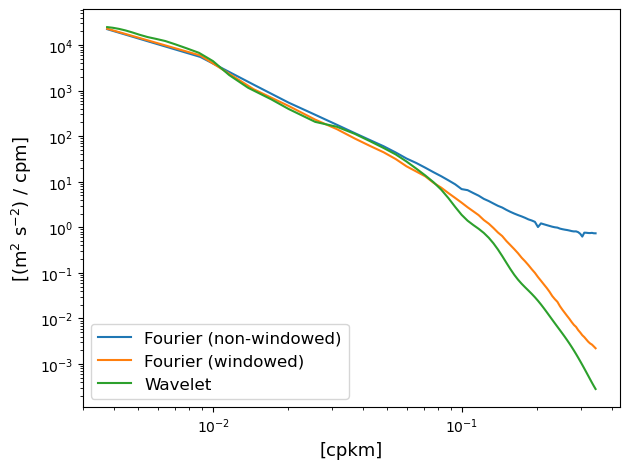

In [46]:
## The strength of wavelets is that they require no windowing
## I.e. no skewing of the data due to windowing

fig, ax = plt.subplots()
fig.set_tight_layout(True)

ax.plot(Feke.freq_r*1e3, Feke*2*np.pi, label='Fourier (non-windowed)')
ax.plot(Feke_win.freq_r*1e3, Feke_win*2*np.pi, label='Fourier (windowed)')
ax.plot(Weke.scale**-1*1e3, Weke.sum('angle')*np.pi/len(Weke.angle), 
        label='Wavelet')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"[cpkm]", fontsize=13)
ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
ax.legend(loc='lower left', fontsize=12)